[구글 코랩(Colab)에서 실행하기](https://colab.research.google.com/github/lovedlim/tensorflow/blob/main/Part%204/4.10_Grad_CAM.ipynb)

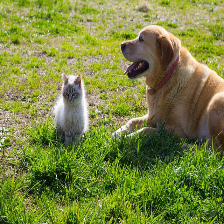

In [ ]:
# 필요한 패키지
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# 개와 고양이가 함께 있는 사진을 불러오고 그려준다
img = cv2.imread('animals.jpg')
img = cv2.resize(img, (224, 224))
cv2_imshow(img)

In [ ]:
# 기본적으로 Cv2는 BGR로 불러오기 때문에 RGB로 변경해 준다.
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# 예측에 쓰일 기본 모델은 VGG16을 사용할 예정이고, 
# block5_conv3 아웃풋과 VGG16 아웃풋을 동시에 가지는 모델을 정의해 준다.
vgg_model=tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=True)
grad_cam_model = tf.keras.models.Model([vgg_model.input], 
                                       [vgg_model.get_layer('block5_conv3').output, vgg_model.output])

# 인풋 이미지를 넣어주고,  block5_conv3 아웃풋과 결과값을 반환한다.
conv_outputs, predictions = grad_cam_model.predict(np.reshape(rgb_img, (1, 224, 224, 3)))

# 가장 예측 확률이 높은 인덱스를 저장하고, Class값을 확인한다.
img_index= np.argmax(predictions)
tf.keras.applications.vgg16.decode_predictions(predictions)

40960/35363 [==================================] - 0s 0us/step


[[('n02099712', 'Labrador_retriever', 0.49398184),
  ('n02092339', 'Weimaraner', 0.24856645),
  ('n02099601', 'golden_retriever', 0.06568341),
  ('n02134084', 'ice_bear', 0.05871958),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.046956137)]]

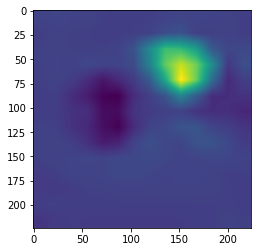

In [ ]:
# 가장 예측이 높은 인덱스에 대한 block5_conv3의 Gradient를 구한다.
with tf.GradientTape() as tape:
    conv_outputs,  predictions = grad_cam_model(np.reshape(rgb_img, (1, 224, 224, 3)))
    loss = predictions[:, img_index]
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

# 음수는 그 결과를 반대하는 결과이므로,  생략한다.
# 즉 Relu를 통해 양의 Gradient만 취해준다.
# grads = tf.keras.activations.relu(grads)

# grad를 채널별로 합해준다.
# 이값이 그 채널의 웨이트값이 된다.
grad_weights = tf.reduce_mean(grads, axis=(0,  1))

# block5_conv3의 아웃풋에 Grad채널의 웨이트값을 곱해준다.
cam = np.ones(output.shape[0: 2], dtype = np.float32)
for i,  w in enumerate(grad_weights):
    cam += w * output[:,  :,  i]

# 크기를 변경해 주고,  0~1 사이의 값을 가지도록 조정해 준다.
cam = cv2.resize(cam.numpy(), (224,  224))
grad_cam = (cam - cam.min()) / (cam.max() - cam.min())

# grad cam이 활성화된 영역을 표시해 본다.
plt.imshow(grad_cam)

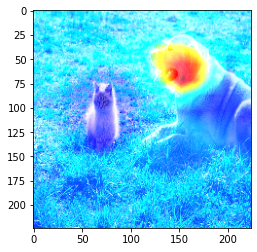

In [ ]:
cam = cv2.applyColorMap(np.uint8(255*grad_cam), cv2.COLORMAP_JET)
cam = cv2.cvtColor(cam, cv2.COLOR_RGB2BGR)
plt.imshow(cv2.add(cam, img))